# Micro- (and hopefully soon geo-) Founded Occupational Mobility Network

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [2]:
# Import packages
from abm_funs import *
import os
import tempfile
import pickle
import statistics
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
import time
import pandas as pd
import random as random
from copy import deepcopy
import matplotlib.pyplot as plt
import math as math
from statistics import mode
import cProfile, pstats, io
from scipy.interpolate import splrep, BSpline
import scipy.stats as scipy
import seaborn as sns
from IPython import display
from pstats import SortKey
from matplotlib.backends.backend_pdf import PdfPages
rng = np.random.default_rng()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

test_fun()

hello - new import works!


## Update for Stefi & Maria

Hi both,

Last we spoke, two of the programmatic items on my list were to move toward what we either wish to be a validation exercise or possibly a headline result of this first project: 

- **Reproduce the gender wage gap** (this is now observed in our behavioural model (yay!) although the scale remains to be adjusted a bit - it seems that my risk aversion/ambition parameter is too steep for women - gender wage gap is too high in the behavioural model).    
- **Reproduce the long-term unemployment rate** (workers end up unempoyed for longer than a year despite vacancies being available). This latter result could be manifesting for a few different reasons:  
    - We have a non-linear search effort function that starts to decline after a worker has been unemployed for six months (this can be changed). Essentially, workers first increase their search effort but start to draw it back down after 6 months of being unemployed.   
    - Possible that there are occupational or gender similarities among those who end up in long-term unemployment. For now, it seems that men seem to exhibit a longer tail of long-term unemployment than men (one possible explanation for this is that because we have varied risk aversion/ambition by gender, women compete for less competitive vacancies than men do, for example). I will produce a chart about the occupational differences   

I think that is good news on both the fronts (gender gaps and long-term unemployment) we were interested in seeing whether behavioural heterogeneity might impact. There are a few things that remain to be cleaned up and calibrated a bit better but I recently spoke with Maria and have a few action items to bring me closer. I will also hope to produce the results below with simulation averages rather than single-run result (I have significantly cut down the run-time of the model with the help of Maria's profiling suggestion, so I am now finally able to do this). 

Unless you are interested in the implementation, you can skip directly to the Results section. 


## Setup

### Agents and Classes

Two functions and three classes are defined:
- (Function) Utility/decision-making function used by workers when deciding which vacancies to apply to. Currently this only looks at a wage differential.
- (Function) Search_effort: Search-effort as a function of time spent unemployed - output is the number of vacancies to apply to.
- (Class) Worker: individual worker has state-specific attributes (current or latest held occupation, time unemployed, whether or not long-term unemployed, current or latest wage held, whether or not they have been hired in the current time step, whether or not they are female, risk aversion score). Additional possible attributes which are for now excluded (occupational history). Worker has one function which is to search and apply for a vacancy.
- (Class) Occupation has an id, list of workers currently employed in that occupation, list of neighboring occupations based on transition adjacency matrix (imperfect solution), current and target demand for labour, list of applicants to open vacancies, and wage). Occupation has two internal functions (1) to separate workers and (2) to update all workers in an occupation after each time step.
- (Class) Vacancy has an occupational id, list of applicants (duplicated above in occupation class...to fix), and a wage (duplicated above in occupation class...to fix). Vacancy has one internal function to hire an applicant.

### Data

In [3]:
# Make global decision as to which data to initialise network on. Current options are "toy" or "USA"
#init = "toy"
init = "USA"

# Make global decision about whether to run the model with behavioural components or not
#  this can also be specified in the simulation function below
behav_spec = False

# Make global decision about whether to run a model with a simulated shock
# For now this is ony incorporated as a simple shock to target demand at one time point - step shift
# need to implement this more carefully and realistically
shock = False

#### Toy Model
Toy model constructed on 5 fake occupations with pre-determined employment, unemployment, vacancies, target demand, and wages.

In [4]:
# ###################################
# # TOY MODEL CONDITIONS AND DATA ###
# ###################################
# if init == "toy":
#     T = 1000
#     del_u = 0.015
#     del_v = 0.009
#     gamma_u = gamma_v = gamma = 0.03
#     # Import information about relevant files to employment/unemployment, target demand, vacancies, etc.

#     A = pd.read_csv(path+"data/small_adj_full.csv", delimiter=';', decimal=',', header=None)
#     employment = pd.read_csv(path+"data/employed.csv", header = None)
#     unemployment = pd.read_csv(path+"data/unemployed.csv", header = None)
#     vacancies = pd.read_csv(path+"data/vacancies.csv", header = None)
#     demand_target = employment + vacancies
#     wages = pd.DataFrame(np.round(np.random.normal(50000, 10000, 5)), columns = ['Wages'])
#     mod_data =  {"A": A, "employment": employment, 
#                  'unemployment':unemployment, 'vacancies':vacancies, 
#                  'demand_target': demand_target, 'wages': wages}


#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics Data and IPUMS.
Data input from replicaiton code in dRC et al 2021: https://zenodo.org/records/4453162


This data should be re-extracted. Perhaps incorporate econometric testing for transition probability/matrix calculations.


In [5]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################
if init == "USA":
    T = 500
    d_u_hat = 0.2
    d_v_hat = 0.15
    #del_v = 0.02
    gamma_u = gamma_v = gamma = 0.08

    A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
    employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/1000)
    # Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
    unemployment = round(employment*(0.05/0.95))
    # Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
    vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
    vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
    # Needs input data...
    demand_target = employment + vacancies
    wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
    gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
    mod_data =  {"A": A, "employment": employment, 
                 'unemployment':unemployment, 'vacancies':vacancies, 
                 'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}
    #calib_params = pd.read_csv(path+"data/calibrated_params.csv", delimiter=',', decimal='.').set_index('Parameter')['Value'].to_dict()


### Initialise Network

In [6]:
####################
# Testing Cell #####
####################
# net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'], 
#                             mod_data['unemployment'], mod_data['vacancies'], 
#                             mod_data['demand_target'], mod_data['A'], mod_data['wages'])

#mod_data['employment'].to_numpy().astype(int)[1]
#net, vacs_temp = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy())
#test = mod_data['employment'].to_numpy()
#print(test[2,0])
#print(test)

# test = np.array(net_temp[0].list_of_employed)

# start_time = time.process_time()
# [k for k in test if k.risk_aversion < 6]
# end_time = time.process_time()
# print("list comprehension")
# print(str(1000*(end_time-start_time)))


# vectorised_start_time = time.process_time()
# np.array(list(filter(lambda x: x.risk_aversion < 6, test)))
# vectorised_end_time = time.process_time()
# print("test vectorized")
# print(str(1000*(vectorised_end_time-vectorised_start_time)))


#### Import calibrated parameters

In [7]:
#gamma_hat = (df['gamma']).mean()
#print("gamma_hat: ", gamma_hat)

#d_u_hat = mode(df['d_u'])
#print("d_u_hat: ", d_u_hat)

#d_v_hat = mode(df['d_v'])
#print("d_v_hat: ", d_v_hat)


# Original parameters that "worked" before calibration
T = 200
# d_u_hat = 0.015
# d_v_hat = 0.009
# #del_v = 0.02
# gamma_u = gamma_v = gamma = 0.08

d_u_hat = 0.029
d_v_hat = 0.024
#del_v = 0.02
gamma_u = gamma_v = gamma = 0.17
bus_amp_test = 0.06

## Model Run

### Initialise network & run behavioural and non-behavioural model


In [8]:
#gamma_hat = (df['gamma']).mean()
#print("gamma_hat: ", gamma_hat)

#d_u_hat = mode(df['d_u'])
#print("d_u_hat: ", d_u_hat)

#d_v_hat = mode(df['d_v'])
#print("d_v_hat: ", d_v_hat)


# Original parameters that "worked" before calibration

T = 100
#d_u_hat = calib_params['d_u']
#d_v_hat = calib_params['d_v']
#del_v = 0.02
#gamma_u = gamma_v = gamma = 0.1


# Results specifications (whether to save as final or not)
final = False
fullpdf = False

# Whether or not to save text file of simulation results and final network
savenew = True
n_sims = 5

net, vacs_temp = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), 
                            mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), 
                            mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), 
                            mod_data['gend_share'].to_numpy(), 1, 1)


In [9]:

# d_u_hat = 0.029
# d_v_hat = 0.024
# #del_v = 0.02
# gamma_u = gamma_v = gamma = 0.17
# bus_amp_test = 0.06

parameters = {'mod_data': mod_data, 
             'net_temp': net,
              'vacs': vacs_temp, 
              'behav_spec': False,
              'time_steps': T,
              'runs': n_sims,
              # Worked pre-WEHIA
              'd_u': 0.029,
              'd_v': 0.022,
              'gamma': 0.18,
              'bus_cycle_len': 36,
              'bus_amp': 0.05}
              
              
              # Stopped testing with these:
                    #        'd_u': 0.035,
              #'d_v': 0.03,
              #'gamma': 0.1,
              #'bus_cycle_len': 36,
              #'bus_amp': 0.055}


# parameters.update({'behav_spec': False,
#                    'd_u': 0.014,
#                    'd_v': 0.01,
#                    'gamma': 0.17,
#                    'bus_amp': 0.05})



# Worked pre-WEHIA
             #'d_u': 0.029,
            #'d_v': 0.024,
            #  'gamma': 0.18,
             # 'bus_cycle_len': 36,
             #> 'bus_amp': 0.065}

# parameters.update({'behav_spec': False,
#                    'd_u': 0.014,
#                    'd_v': 0.01,
#                    'gamma': 0.17,
#                    'bus_amp': 0.05})



#print(parameters)


if savenew:
    # pr = cProfile.Profile()
    # pr.enable()

    # Run model without behavioural spec
    #sim_record_f_all, net_nonbehav, net_nonbehav_list = run_sim(net, vacs_temp, False, T, n_sims, d_u_hat, d_v_hat)
    sim_record_f_all, net_nonbehav, net_nonbehav_list = run_sim(**parameters)

    # pr.disable()
    # s = io.StringIO()
    # sortby = SortKey.CUMULATIVE
    # ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    # ps.print_stats()
    # print(s.getvalue())
    
else:
    os.chdir('..')
     # Load the 2D array from the CSV file
    loaded_arr_f = np.loadtxt("output/usa/sim_100_behav_false.csv", delimiter=",")    
    # Reshape the 2D array back to its original 3D shape
    sim_record_f_all = loaded_arr_f.reshape((116464, 8, n_sims))

    with open("net_nonbehav.pickle", 'rb') as f:
        net_nonbehav = pickle.load(f)
        
    with open("net_nonbehav_list.pickle", 'rb') as f:
        net_nonbehav_list = pickle.load(f)

Run:  0
Done after  100  time steps.
(564, 8)
Run:  1
Done after  100  time steps.
(564, 8, 2)
Run:  2
Done after  100  time steps.
(564, 8, 3)
Run:  3
Done after  100  time steps.
(564, 8, 4)
Run:  4
Done after  100  time steps.
(564, 8, 5)
Done after  5  runs.


In [10]:
parameters.update({'behav_spec': True,
                   'd_u': 0.016,
                   'd_v': 0.01,
                   'gamma': 0.13,
                   'bus_amp': 0.05})

if savenew:
    # Run behavioural spec
    # pr = cProfile.Profile()
    # pr.enable()

    # Run model with behavioural spec
    sim_record_t_all, net_behav, net_behav_list = run_sim(**parameters)

#     # pr.disable()
#     # s = io.StringIO()
#     # sortby = SortKey.CUMULATIVE
#     # ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
#     # ps.print_stats()
#     # print(s.getvalue())
    
# else:
#      # Load the 2D array from the CSV file
#     loaded_arr_t = np.loadtxt("output/usa/sim_100_behav_true.csv", delimiter=",")    
#     # Reshape the 2D array back to its original 3D shape
#     sim_record_t_all = loaded_arr_t.reshape((116464, 8, n_sims))

#     with open("net_behav.pickle", 'rb') as f:
#         net_behav = pickle.load(f)
    
#     with open("net_behav_list.pickle", 'rb') as f:
#         net_behav_list = pickle.load(f)

Run:  0
Done after  100  time steps.
(564, 8)
Run:  1
Done after  100  time steps.
(564, 8, 2)
Run:  2
Done after  100  time steps.
(564, 8, 3)
Run:  3
Done after  100  time steps.
(564, 8, 4)
Run:  4
Done after  100  time steps.
(564, 8, 5)
Done after  5  runs.


### Save simulation results

In [11]:
# #if savenew:
#     #os.chdir('..')
#     #os.chdir('transition_abm/')
    
#     with open("net_behav.pickle", 'wb') as f:
#         pickle.dump(net_behav, f)
#     with open("net_nonbehav.pickle", 'wb') as f:
#         pickle.dump(net_nonbehav, f)
        
#     with open("net_behav_list.pickle", 'wb') as f:
#         pickle.dump(net_behav_list, f)
#     with open("net_nonbehav_list.pickle", 'wb') as f:
#         pickle.dump(net_nonbehav_list, f)
        
#     # Create a sample 3D array
#     arr_t = sim_record_t_all
#     arr_f = sim_record_f_all

#     # Reshape the 3D array to 2D
#     arr_t_reshaped = arr_t.reshape(arr_t.shape[0], -1)
#     arr_f_reshaped = arr_f.reshape(arr_f.shape[0], -1)

#     # Save the 2D array to a CSV file
#     np.savetxt("output/usa/sim_100_behav_true.csv", arr_t_reshaped, delimiter=",")
#     # Save the 2D array to a CSV file
#     np.savetxt("output/usa/sim_100_behav_false.csv", arr_f_reshaped, delimiter=",")

#     # Load the 2D array from the CSV file
#     loaded_arr_t = np.loadtxt("output/usa/sim_100_behav_true.csv", delimiter=",")
#     # Load the 2D array from the CSV file
#     loaded_arr_f = np.loadtxt("output/usa/sim_100_behav_false.csv", delimiter=",")

#     # Reshape the 2D array back to its original 3D shape
#     load_original_arr_t = loaded_arr_t.reshape((arr_t.shape[0], arr_t.shape[1], arr_t.shape[2]))
#     # Reshape the 2D array back to its original 3D shape
#     load_original_arr_f = loaded_arr_f.reshape((arr_f.shape[0], arr_f.shape[1], arr_f.shape[2]))

#     # Verify if the loaded array matches the original
#     if np.array_equal(load_original_arr_t, sim_record_t_all):
#         print("Yes, both behavioural arrays are the same")
#     else:
#         print("No, both the behavioural arrays are not the same")

#     # Verify if the loaded array matches the original
#     if np.array_equal(load_original_arr_f, sim_record_f_all):
#         print("Yes, both non-behavioural arrays are the same")
#     else:
#         print("No, both the non-behavioural arrays are not the same")
        

# Results

Below I present the results from a model run over 500 time steps (where relevant, I show the initial network that is passed to the function that "runs" the model behaviour and that therefore has not reached a "steady state"). 

## Beveridge curve validation

Color of the below plots go from purple to yellow as time increases. So we do observe a countercyclical beveridge curve. I will need to read more closely what behaviour is expected of the beveridge curve....not sure if the circular shape of this is in line with real-world patterns (rather than a somewhat elliptical shape). Furthermore, Maria has mentioned that the Beveridge curve does not "close". Ours does here so far. Will look into this further. 

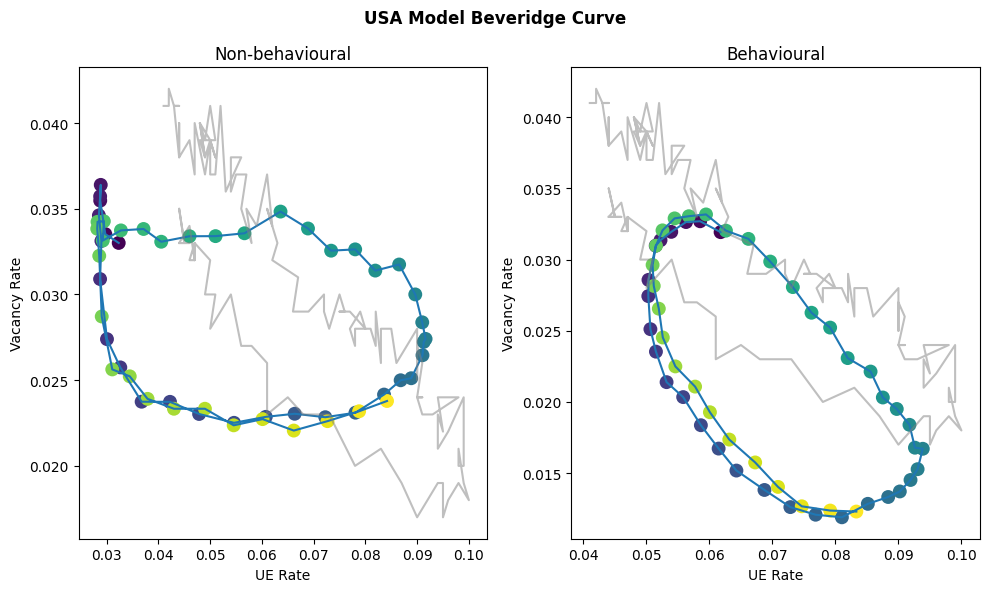

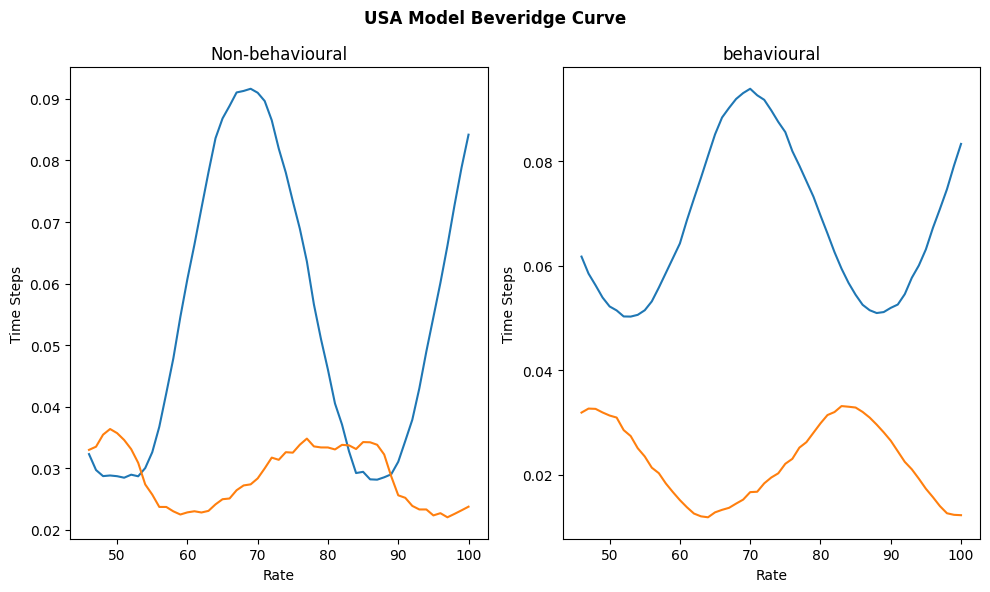

     index       DATE  UNRATE    UER  FD_UNRATE  JTSJOR  VACRATE  FD_VACRATE
0      211 2006-12-01     4.4  0.044     -0.001     3.3    0.033       0.000
1      212 2007-01-01     4.6  0.046      0.002     3.3    0.033       0.000
2      213 2007-02-01     4.5  0.045     -0.001     3.3    0.033       0.000
3      214 2007-03-01     4.4  0.044     -0.001     3.5    0.035       0.002
4      215 2007-04-01     4.5  0.045      0.001     3.3    0.033      -0.002
..     ...        ...     ...    ...        ...     ...      ...         ...
128    339 2017-08-01     4.4  0.044      0.001     4.1    0.041       0.000
129    340 2017-09-01     4.3  0.043     -0.001     4.1    0.041       0.000
130    341 2017-10-01     4.2  0.042     -0.001     4.2    0.042       0.001
131    342 2017-11-01     4.2  0.042      0.000     4.1    0.041      -0.001
132    343 2017-12-01     4.1  0.041     -0.001     4.1    0.041       0.000

[133 rows x 8 columns]


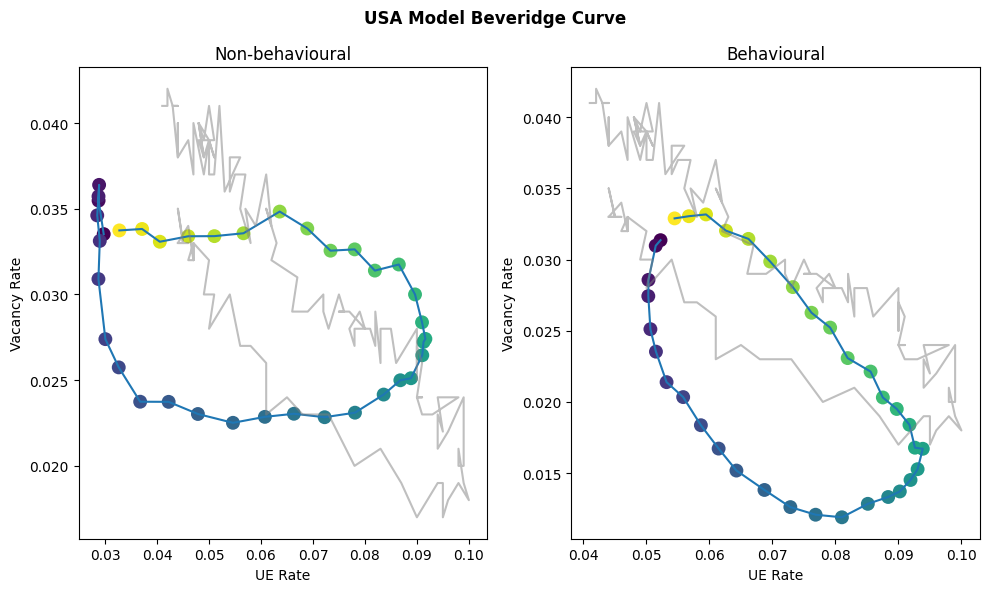

In [15]:
# Summary values for one run 
sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
sim_record_t.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
sim_record_f.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']

record1_t = sim_record_t[(sim_record_t['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()
record1_f = sim_record_f[(sim_record_f['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()

end_t = record1_t[(record1_t['Time Step'] == T)]
end_f = record1_f[(record1_f['Time Step'] == T)]

unrate = pd.read_csv(path+"data/macro_vars/UNRATE.csv", delimiter=',', decimal='.')
unrate["DATE"] = pd.to_datetime(unrate["DATE"])
unrate["UER"] = unrate['UNRATE']/100
unrate['FD_UNRATE'] = pd.Series(unrate['UER']).diff()

# Monthly, seasonally adjusted job openings rate (total nonfarm)
# Source: https://fred.stlouisfed.org/series/JTSJOR

jorate = pd.read_csv(path+"data/macro_vars/JTSJOR.csv", delimiter=',', decimal='.')
jorate["DATE"] = pd.to_datetime(jorate["DATE"])
jorate["VACRATE"] = jorate['JTSJOR']/100
jorate['FD_VACRATE'] = pd.Series(jorate['VACRATE']).diff()

macro_observations = pd.merge(unrate, jorate, how = 'outer', on = 'DATE')
macro_abbrev = macro_observations.loc[(macro_observations['DATE'] >= "2006-12-01") & (macro_observations['DATE'] <= "2017-12-01")].reset_index()

# plt.plot(macro_abbrev['UER'], macro_abbrev['VACRATE'])
# plt.title("Real US Beveridge Curve")
# plt.ylabel("Vacancy Rate")
# plt.xlabel("UER")

ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
ue_vac_f = ue_vac_f[46:]

ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
ue_vac_t = ue_vac_t[46:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
ax1.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
ax2.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(ue_vac_f['UE Rate'])
ax1.plot(ue_vac_f['Vac Rate'])
ax1.set_title("Non-behavioural")
ax1.set_xlabel("Rate")
ax1.set_ylabel("Time Steps")

ax2.plot(ue_vac_t['UE Rate'])
ax2.plot(ue_vac_t['Vac Rate'])
ax2.set_title("behavioural")
ax2.set_xlabel("Rate")
ax2.set_ylabel("Time Steps")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()

#if final:
#    plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
#else:
plt.show()
plt.close()

ue_vac_f = ue_vac_f[1:38]
ue_vac_t = ue_vac_t[4:40]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
ax1.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
ax2.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c="grey", alpha = 0.5)
plt.title("Behavioural")
plt.xlabel("Vacancy Rate")
plt.ylabel("UER")
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
#plt.savefig('../output/usa/testing_bev_cycle.jpg', dpi = 300)
fig.tight_layout()



# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
# ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
# #ax1.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c = "grey", alpha = 0.5)
# ax1.set_title("Non-behavioural")
# ax1.set_xlabel("UE Rate")
# ax1.set_ylabel("Vacancy Rate")

# #ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
# ax2.set_title("Behavioural")
# #ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
# #ax2.plot(macro_abbrev['UER'],macro_abbrev['VACRATE'], c="grey", alpha = 0.5)
# plt.title("Behavioural")
# plt.xlabel("Vacancy Rate")
# plt.ylabel("UER")
# ax2.set_xlabel("UE Rate")
# ax2.set_ylabel("Vacancy Rate")

    
# fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
# #plt.savefig('../output/usa/beveridge_behav_0_1_single_cycle.jpg', dpi = 300)

# plt.show()
# plt.close()




## Gender Wage Gaps

I have incorporated data about the gender shares into the initialisation function of the network from the Bureau of Labour Statistics [Current Population Survey](https://www.bls.gov/cps/cpsaat11.htm). Occupations are populated with employed and unemployed workers in line with each occupation's gender shares in the initialise function. 

The plots immediately below show (from left to right): initialised network (the return value of initialise); steady state behaviour of non-behavioural model; steady state behaviour of behavioural model.

Some things to note:
- **The gender wage gap below is not corrected for occupational choice** (rather it is almost entirely a result of occupational choice by design). The 13% gender wage gap in the initialised model (before model run) is in line with US gender wage gaps not corrected for occupational choice (I was very happy to see this!).      

- **However, the steady-state behaviour of the non-behavioural and behavioural models lead to the disappearance (0%  wage gap) or exacerbation  (38% wage gape) of this gender wage gap in the steady-state, respectively.** We would ideally want the non-behavioural one to match the real-world gender wage gap. As mentioned above, this can likely be calibrated by adjusting the risk aversion parameters I've differed across genders. I will play around with this and see if I can get closer to the truth. The results in the non-behavioural case is not surprising...all people behave the same, essentially.         

- I am a bit concerned about the result in the non-behavioural case since the transition options should differ for men and women because of the different occupations they "start" in so I don't quite understand why the gender wage gap does not persist. I will investigate this further too...    

Gender Distribution Data from 2022
https://www.neilsberg.com/research/datasets/2445ffc0-981b-11ee-99cf-3860777c1fe6/
American Community Survey aggregated and distributed by Neilsberg

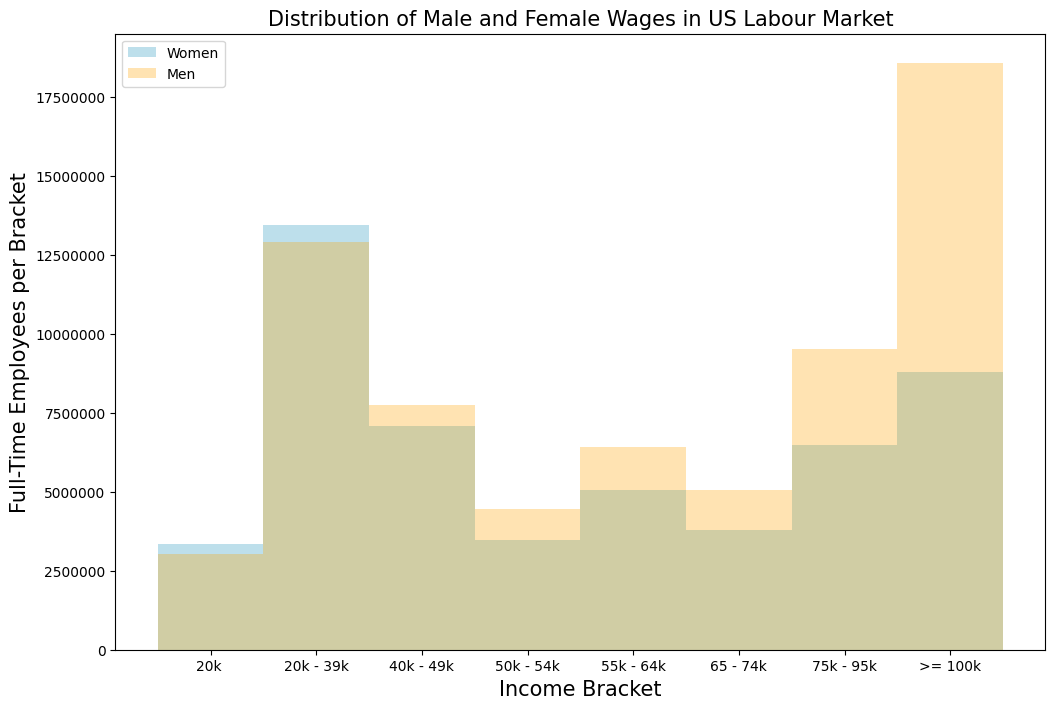

61354.82019159919


69250.7515119483

In [20]:
gender_income = pd.read_csv(path+"data/gender_income_distribution_usa_2022.csv", delimiter=',', thousands = ",")

gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or loss', '')
gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or more', '')
gender_income['Ceiling'] = gender_income['Income Bracket'].str[-7:]
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(',', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace('$', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(' ', '')
gender_income['Ceiling'] = gender_income['Ceiling'].astype('Int64')
gender_income.loc[0:7, 'Bracket'] = "20k "
gender_income.loc[8:12, 'Bracket'] = "20k - 39k"
gender_income.loc[13:14, 'Bracket'] = "40k - 49k"
gender_income.loc[15, 'Bracket'] = "50k - 54k"
gender_income.loc[16, 'Bracket'] = "55k - 64k"
gender_income.loc[17, 'Bracket'] = "65 - 74k"
gender_income.loc[18, 'Bracket'] = "75k - 95k"
gender_income.loc[19, 'Bracket'] = ">= 100k"
brackets = gender_income.groupby(['Bracket']).sum().reset_index()

barWidth = 1
fig = plt.subplots(figsize =(12, 8)) 
br1 = np.arange(len(brackets['Bracket'])) + 1
br2 = br1
 
# Make the plot
plt.bar(br1, brackets['Full-Time Females'], color ='lightblue', width = barWidth, alpha = 0.8,
         label ='Women') 
plt.bar(br2, brackets['Full-Time Males'], color ='orange', width = barWidth, alpha = 0.3,
        label ='Men') 


# Adding Xticks 
plt.xlabel('Income Bracket', fontsize = 15) 
plt.ylabel('Full-Time Employees per Bracket', fontsize = 15) 
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
        brackets['Bracket'])

plt.title('Distribution of Male and Female Wages in US Labour Market', fontsize = 15) 
plt.legend()
plt.show() 

womens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Females']).sum()/(gender_income['Full-Time Females'].sum())
mens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Males']).sum()/(gender_income['Full-Time Males'].sum())

print(womens_wage)
mens_wage

--------------------
--------------------
0
674146
1
674437


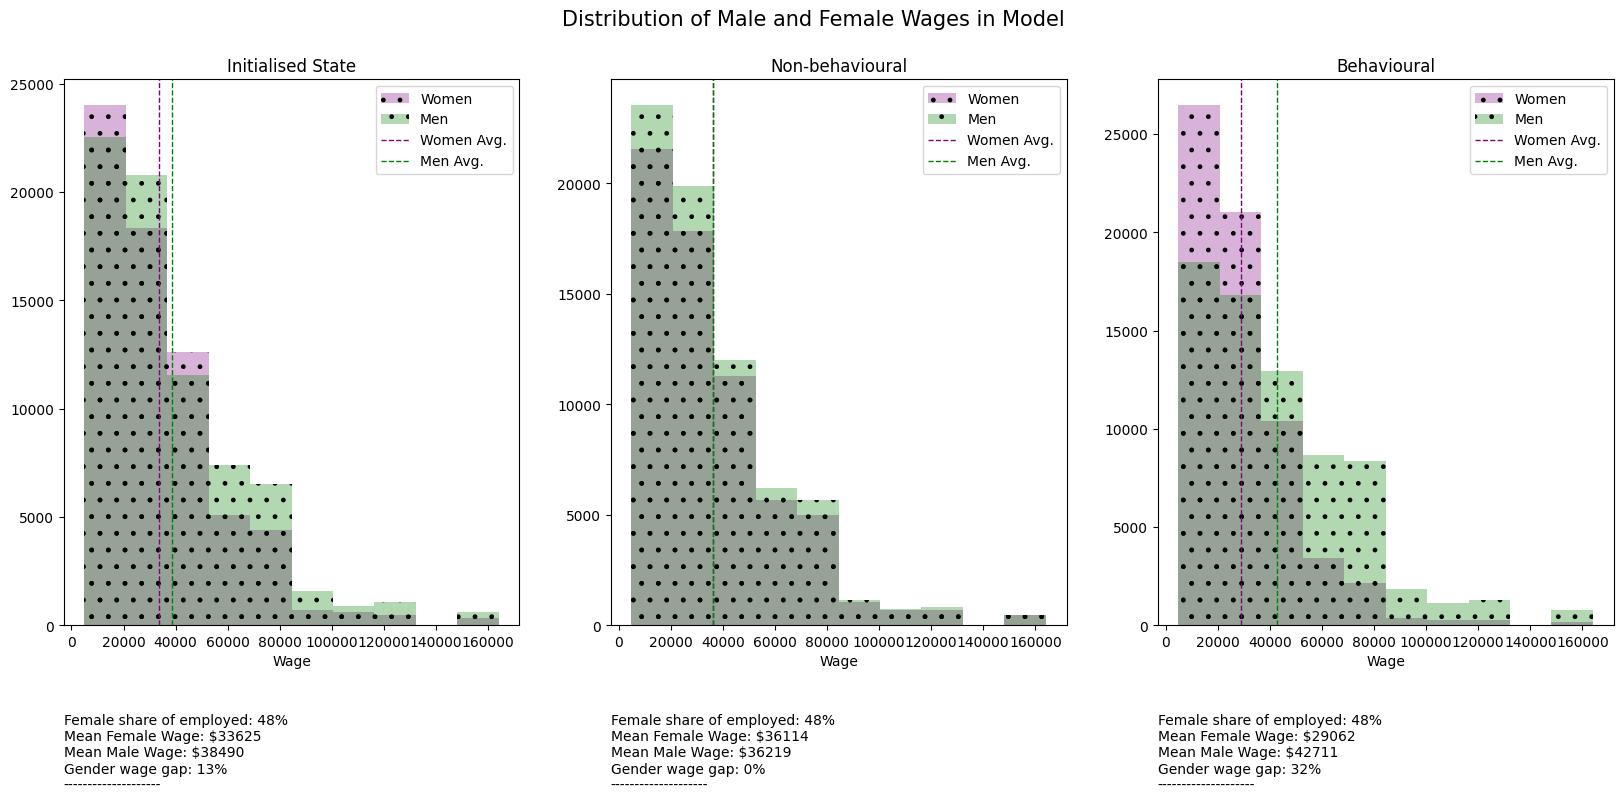

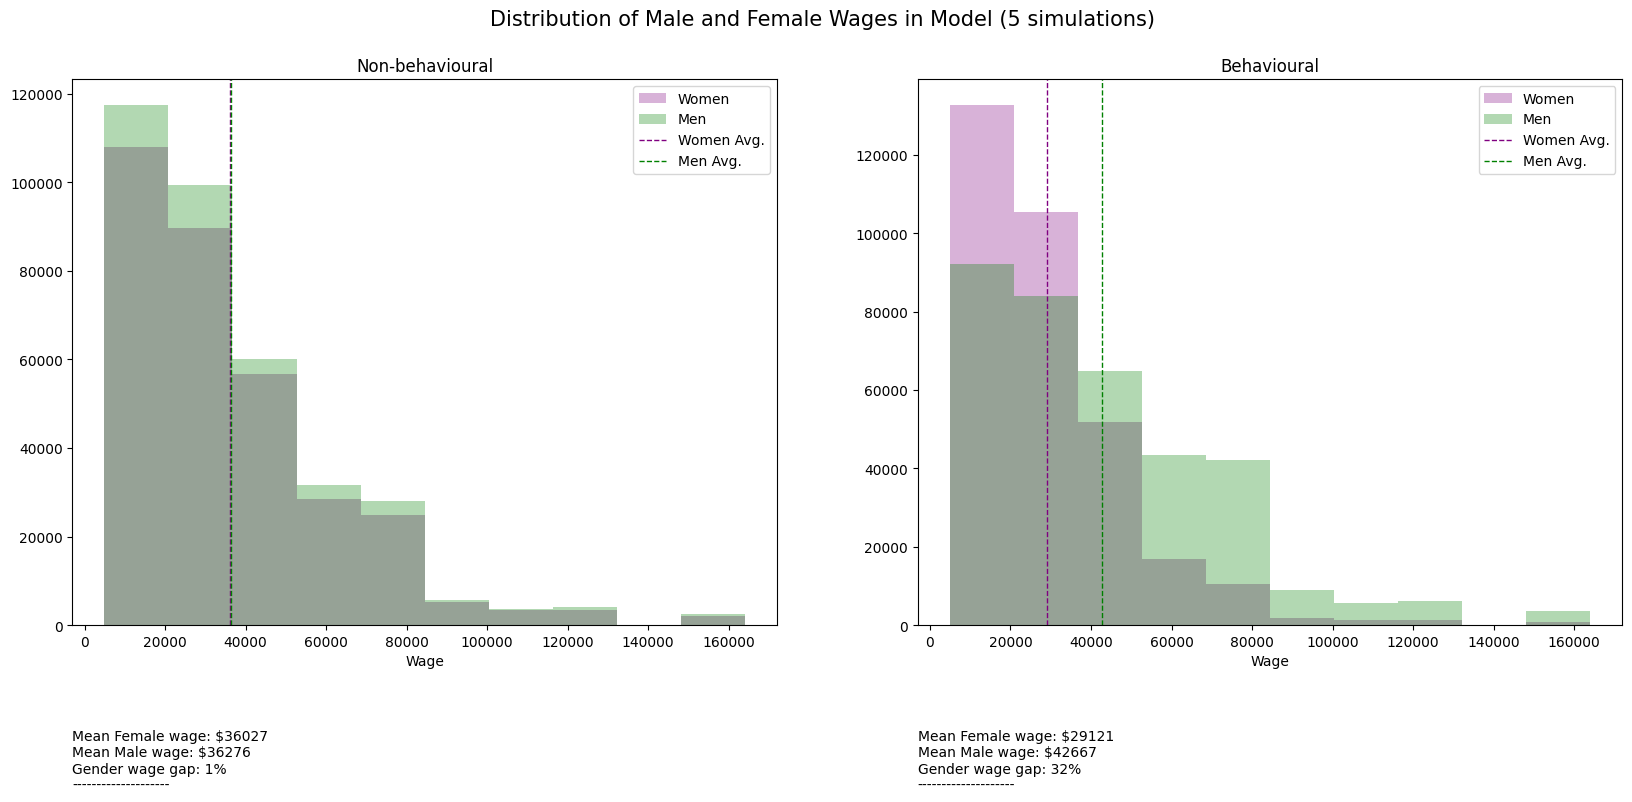

In [21]:
# # Confirm a wage gap in the init state and behavioural models! A little high in the behavioural model...and 0 in the non-behavioural....
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
print("--------------------")
for i, k in enumerate([net, net_nonbehav, net_behav]):
    emp_counter = 0
    women = 0
    men = 0

    w_wages = []
    m_wages = []

    w_wage = 0
    m_wage = 0

    for occ in k:
        emp_counter += len(occ.list_of_employed)
        women += len([wrkr for wrkr in occ.list_of_employed if wrkr.female])
        men += len([wrkr for wrkr in occ.list_of_employed if not(wrkr.female)])
        w_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
        m_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
        w_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
        m_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
    
        
    t= " \n" + " \n" + "Female share of employed: " + str(round((women/emp_counter)*100)) + "% \n" + "Mean Female Wage: $" + str(round(w_wage/women)) + "\n" + "Mean Male Wage: $" + str(round(m_wage/men)) + "\n" + "Gender wage gap: " + str(round(100*(1 - (w_wage/women)/(m_wage/men)))) + "%" + "\n" + "--------------------"

    n_bins = 10
    women = np.array(w_wages)
    men = np.array(m_wages)

    # We can set the number of bins with the *bins* keyword argument.
    ax[i].hist(women, bins=n_bins, alpha = 0.3, color = 'purple', label = 'Women', fill = True, hatch = '.')
    ax[i].hist(men, bins=n_bins, alpha = 0.3, label = 'Men', color = 'green', fill = True, hatch = '.')  
    ax[i].axvline(women.mean(), color='purple', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i].axvline(men.mean(), color='green', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i].legend(loc='upper right') 
    ax[i].annotate(t, xy = (0, -0.3), xycoords='axes fraction')
    ax[0].set_title('Initialised State')
    ax[1].set_title('Non-behavioural')
    ax[2].set_title('Behavioural')  
    ax[0].set_xlabel('Wage')
    ax[1].set_xlabel('Wage')
    ax[2].set_xlabel('Wage')  

    
fig.suptitle('Distribution of Male and Female Wages in Model', fontsize = 15) 
fig.subplots_adjust(bottom=0.1)

#if final:
plt.savefig('../output/usa/wage_gaps.jpg', dpi = 300)
#else:
 #   plt.show()
#plt.close()


## All simulations
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
print("--------------------")
for i, lst in enumerate([net_nonbehav_list, net_behav_list]):
    print(i)
    emp_counter = 0
    women = 0
    men = 0

    w_wages = []
    m_wages = []

    w_wage = 0
    m_wage = 0
    for net_l in lst:
        for occ in net_l:
            emp_counter += len(occ.list_of_employed)
            women += len([wrkr for wrkr in occ.list_of_employed if wrkr.female])
            men += len([wrkr for wrkr in occ.list_of_employed if not(wrkr.female)])
            w_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
            m_wages.extend([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])
            w_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if wrkr.female])
            m_wage += sum([wrkr.wage for wrkr in occ.list_of_employed if not(wrkr.female)])

    print(emp_counter)
    t= " \n" + " \n" + "Mean Female wage: $" + str(round(w_wage/women)) + "\n" + "Mean Male wage: $" + str(round(m_wage/men)) + "\n" + "Gender wage gap: " + str(round(100*(1 - (w_wage/women)/(m_wage/men)))) + "%" + "\n" + "--------------------"

    n_bins = 10
    women = np.array(w_wages)
    men = np.array(m_wages)

    # We can set the number of bins with the *bins* keyword argument.
    ax[i].hist(women, bins=n_bins, alpha = 0.3, color = 'purple', label = 'Women')
    ax[i].hist(men, bins=n_bins, alpha = 0.3, color = 'green', label = 'Men')  
    ax[i].axvline(women.mean(), color='purple', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i].axvline(men.mean(), color='green', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i].legend(loc='upper right') 
    ax[i].annotate(t, xy = (0, -0.3), xycoords='axes fraction')
    ax[0].set_title('Non-behavioural')
    ax[1].set_title('Behavioural')  
    ax[i].set_xlabel('Wage')
fig.suptitle('Distribution of Male and Female Wages in Model ('+str(n_sims)+' simulations)', fontsize = 15) 
fig.subplots_adjust(bottom=0.1)

#if final:
plt.savefig('../output/usa/wage_gaps_sim_100.jpg', dpi = 300)
#else:
#    plt.show()
#plt.close()


## LTUER

The following plot shows the distribution of time spent unemployed for workers in the US economy. From top to bottom: initialised network (the return value of initialise); steady state behaviour of non-behavioural model; steady state behaviour of behavioural model. Left-hand panels show the distribution for workers overall; right-hand panel shows the overlapping distributions for men and women. The graphs share an x-axis to be able to compare the distribution across models.

Takeaways: 

- **The behavioural model evidently leads to a longer tail of long-term unemployment in the steady state model.** This is exactly the result we wanted to see!
- **Men tend to have a longer tail than women in the behavioural model.** I will investigate whether this could be because of occupational differences or rather a symptom of the fact that they "aim higher" when applying to vacancies. 

These resuls have yet to be thoroughly tested and indeed calibration remains to be done. But for now, promising support for our hypothesis that behavioural mechanisms (search effort and heterogeneous preferences across genders) lead to different behaviours and might 'contribute' to the real-world long tail of long-term unemployment rate.


LTUER Distribution from BLS
https://www.bls.gov/news.release/empsit.t12.htm

  NUMBER OF UNEMPLOYED  Unnamed: 1  Min  Max    No        Dist  Repeat
0    Less than 5 weeks         NaN    0    4  1909  477.250000       4
1        5 to 14 weeks         NaN    5   14  2141  237.888889       9
2       15 to 26 weeks         NaN   15   26  1195  108.636364      11
3    27 weeks and over         NaN   27  150  1359   11.048780     123


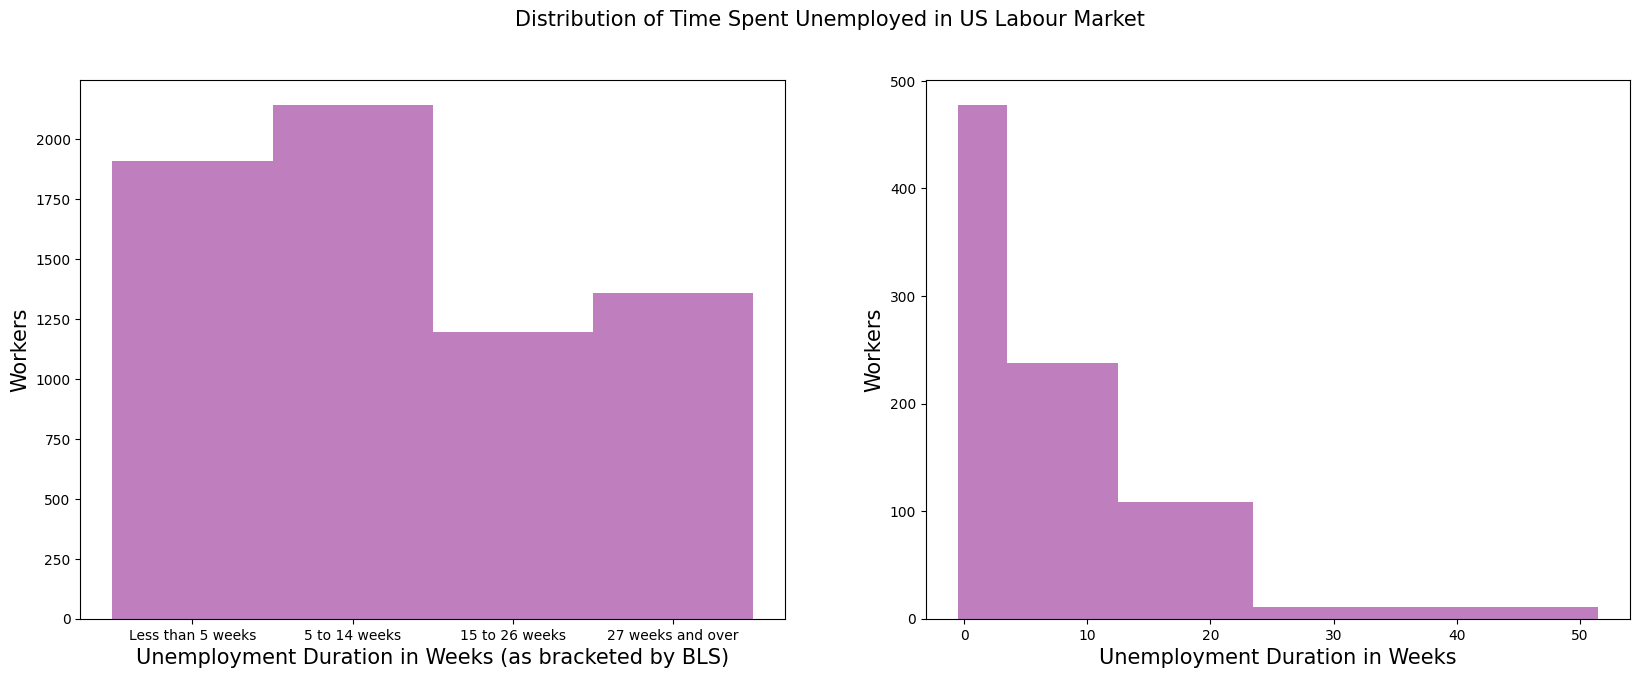

In [22]:
ltuer = pd.read_csv(path+"data/ltuer_april_2023.csv", delimiter=';', thousands = ",")

ltuer['Dist'] = ltuer['No']/(ltuer['Max'] - ltuer['Min'])
ltuer['Repeat'] = ltuer['Max'] - ltuer['Min']
print(ltuer)

# Sample data
data = {'Value_to_repeat': ltuer['Dist'],
        'Repeat_times': ltuer['Repeat']}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a new DataFrame with repeated values
df_repeated = pd.DataFrame({
    'No Workers': df['Value_to_repeat'].repeat(df['Repeat_times']),
    'Original_Index': df.index.repeat(df['Repeat_times'])
})

# Reset the index if needed
df_repeated.reset_index(drop=True, inplace=True)
df_short = df_repeated[0:52]

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
barWidth = 1
 
# Make the plot
ax[1].bar(df_short.index, df_short['No Workers'], color ='purple', width = barWidth, alpha = 0.5) 

# Adding Xticks 
ax[1].set_xlabel('Unemployment Duration in Weeks', fontsize = 15) 
ax[1].set_ylabel('Workers', fontsize = 15) 
#ax[1].set_ticklabel_format(useOffset=False, style='plain')
#ax[1].set_xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
#      brackets['Bracket'])
 
# Make the plot
ax[0].bar(ltuer['NUMBER OF UNEMPLOYED'], ltuer['No'], color ='purple', width = barWidth, alpha = 0.5) 

# Adding Xticks 
ax[0].set_xlabel('Unemployment Duration in Weeks (as bracketed by BLS)', fontsize = 15) 
ax[0].set_ylabel('Workers', fontsize = 15) 
#ax[0].ticklabel_format(useOffset=False, style='plain')
#ax[0].xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
 #       brackets['Bracket'])
 
fig.suptitle('Distribution of Time Spent Unemployed in US Labour Market', fontsize = 15) 
plt.show() 


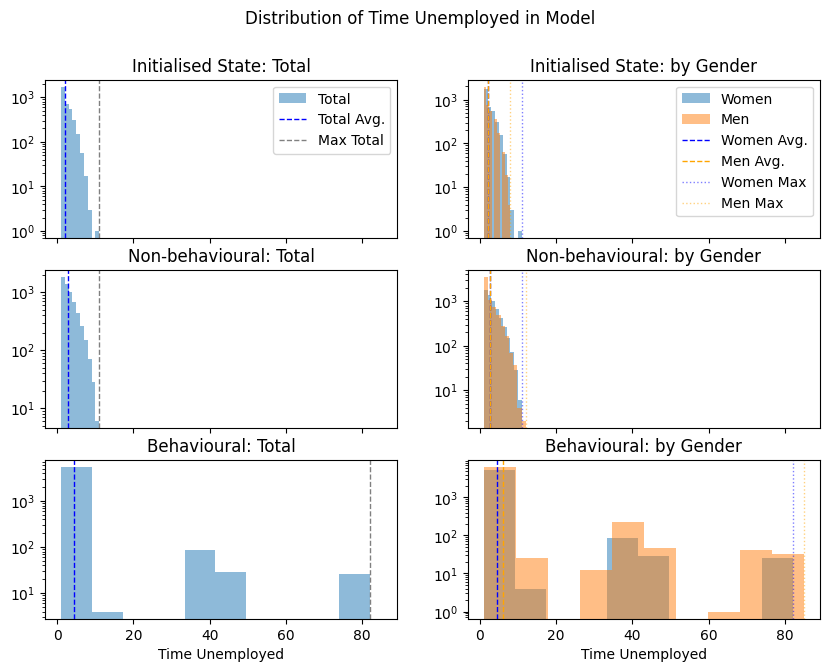

--------------------


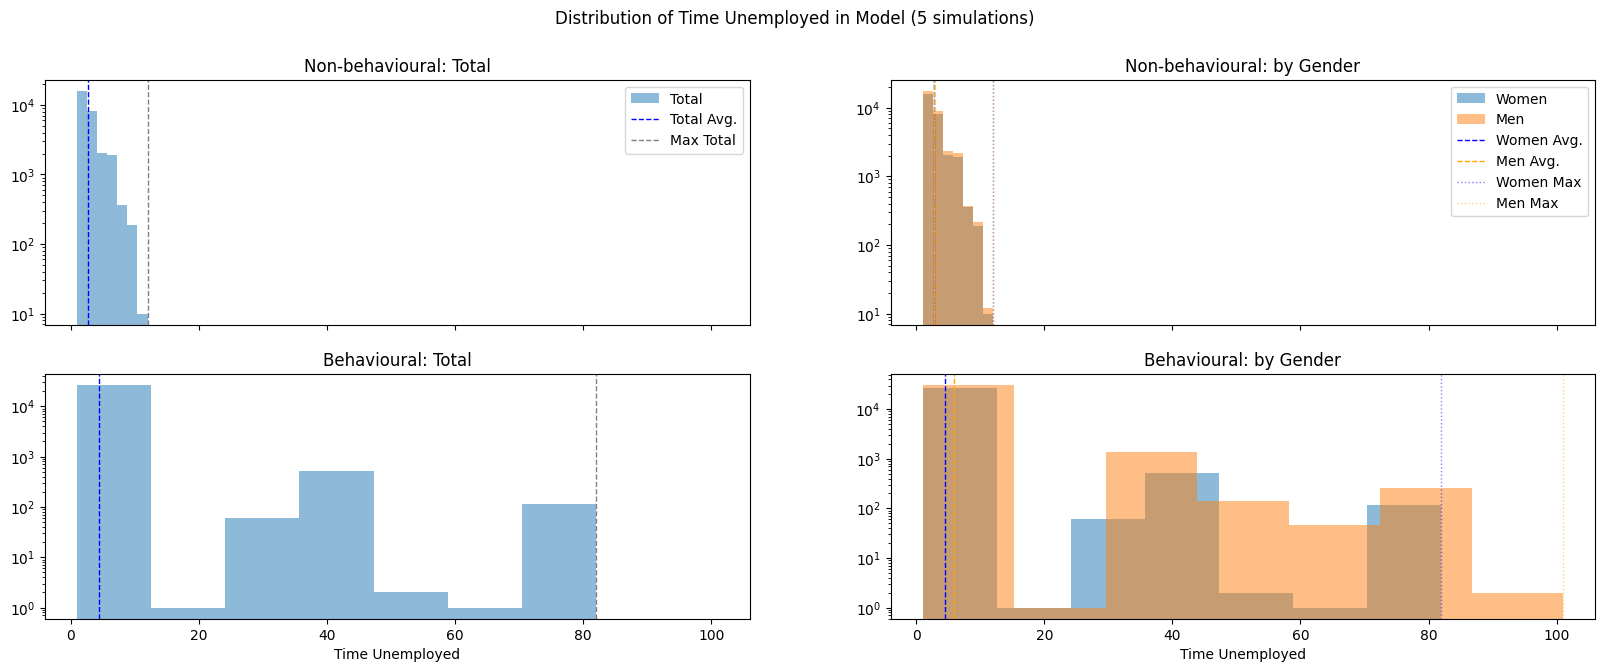

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7), sharex = True)

for i, k in enumerate([net, net_nonbehav, net_behav]):
    w_time_unemp = []
    m_time_unemp = []

    for occ in k:
        w_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if wrkr.female])
        m_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if not(wrkr.female)])

    women = np.array(w_time_unemp)
    men = np.array(m_time_unemp)
    total = np.array(w_time_unemp)
    n_bins = 10

    # We can set the number of bins with the *bins* keyword argument.
    ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
    ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
    ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
    ax[0,0].legend(loc='upper right') 
    ax[0,0].set_title('Non-behavioural')
    ax[1,0].set_title('Behavioural')  
    
    ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
    ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
    ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Max')
    ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Max')
    ax[0,1].legend(loc='upper right')
    ax[0,0].set_title('Initialised State: Total')
    ax[0,1].set_title('Initialised State: by Gender')
    ax[1,0].set_title('Non-behavioural: Total')
    ax[1,1].set_title('Non-behavioural: by Gender')
    ax[2,0].set_title('Behavioural: Total')  
    ax[2,1].set_title('Behavioural: by Gender')
    ax[2,0].set_xlabel("Time Unemployed")
    ax[2,1].set_xlabel("Time Unemployed")
    
    ax[i,0].set_yscale("log")
    ax[i,1].set_yscale("log")

fig.suptitle('Distribution of Time Unemployed in Model') 
if final:
    plt.savefig('../output/usa/ltuer_distributions.jpg', dpi = 300)
else:
    plt.show()
plt.close()

## All simulations
fig, ax = plt.subplots(2, 2, figsize=(20, 7), sharex = True)
print("--------------------")
for i, lst in enumerate([net_nonbehav_list, net_behav_list]):
    w_time_unemp = []
    m_time_unemp = []
    for net_l in lst:
        for occ in net_l:
            w_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if wrkr.female])
            m_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if not(wrkr.female)])

    women = np.array(w_time_unemp)
    men = np.array(m_time_unemp)
    total = np.array(w_time_unemp)
    n_bins = 7

    # We can set the number of bins with the *bins* keyword argument.
    ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
    ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
    ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
    ax[0,0].legend(loc='upper right') 
    ax[0,0].set_title('Non-behavioural')
    ax[1,0].set_title('Behavioural')  
    
    ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
    ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
    ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
    ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
    ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Max')
    ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Max')
    ax[0,1].legend(loc='upper right')
    ax[0,0].set_title('Non-behavioural: Total')
    ax[0,1].set_title('Non-behavioural: by Gender')
    ax[1,0].set_title('Behavioural: Total')  
    ax[1,1].set_title('Behavioural: by Gender')
    ax[1,0].set_xlabel("Time Unemployed")
    ax[1,1].set_xlabel("Time Unemployed")
    ax[i,0].set_yscale("log")
    ax[i,1].set_yscale("log")
    #ax[i,0].set_yticklabels_format(useOffset=False, style='plain')
fig.suptitle('Distribution of Time Unemployed in Model ('+str(n_sims)+' simulations)') 

if final:
    plt.savefig('../output/usa/ltuer_distributions_sim_100.jpg', dpi = 300)
else:
    plt.show()
plt.close()



### By Occupation

In [24]:
# ltuer_occ_t = pd.DataFrame(end_t['LT Unemployed Persons']/end_t['Workers'])
# ltuer_occ_f = pd.DataFrame(end_f['LT Unemployed Persons']/end_f['Workers'])

# fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex = True)

# ax[0,0].hist(ltuer_occ_f, alpha = 0.5)
# ax[0,1].hist(ltuer_occ_t, alpha = 0.5)
# ax[0,0].set_xlabel("LTUER")
# ax[0,1].set_xlabel("LTUER")

# ax[1,0].scatter(x = ltuer_occ_f, y = mod_data['wages'])#, c = mod_data['gend_share'], cmap = 'viridis')
# ax[1,1].scatter(x = ltuer_occ_t, y = mod_data['wages'])#, c = mod_data['gend_share'], cmap = 'viridis')
# ax[1,0].set_xlabel("LTUER")
# ax[1,1].set_xlabel("LTUER")
# ax[1,0].set_ylabel("Wages")
# ax[1,1].set_ylabel("Wages")


# ax[2,0].scatter(x = ltuer_occ_f, y = ltuer_occ_f['Gender Share'], s = ltuer_occ_f['Wages']/1000)
# ax[2,1].scatter(x = ltuer_occ_t, y = ltuer_occ_t['Gender Share'], s = ltuer_occ_f['Wages']/1000)

# for i, k in enumerate([net_nonbehav, net_behav]):
#     time_unemp = []

#     for occ in k:
#         time_unemp.append([wrkr.time_unemployed for wrkr in occ.list_of_unemployed])

#     #women = np.array(w_time_unemp)
#     #men = np.array(m_time_unemp)
#     total = np.array(time_unemp)
#     n_bins = 5

    # We can set the number of bins with the *bins* keyword argument.
#     ax[i,0].hist(total, bins=n_bins, alpha = 0.5, label = 'Total')
#     ax[i,0].axvline(total.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Total Avg.')
#     ax[i,0].axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
#     ax[0,0].legend(loc='upper right') 
#     ax[0,0].set_title('Non-behavioural')
#     ax[1,0].set_title('Behavioural')  
    
#     ax[i,1].hist(women, bins=n_bins, alpha = 0.5, label = 'Women')
#     ax[i,1].hist(men, bins=n_bins, alpha = 0.5, label = 'Men')  
#     ax[i,1].axvline(women.mean(), color='blue', linestyle='dashed', linewidth=1, label = 'Women Avg.')
#     ax[i,1].axvline(men.mean(), color='orange', linestyle='dashed', linewidth=1, label = 'Men Avg.')
#     ax[i,1].axvline(women.max(), color='blue', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Women Total')
#     ax[i,1].axvline(men.max(), color='orange', alpha = 0.5, linestyle='dotted', linewidth=1, label = 'Men Total')
#     ax[0,1].legend(loc='upper right')
#     ax[0,0].set_title('Non-behavioural: Total')
#     ax[0,1].set_title('Non-behavioural: by Gender')
#     ax[1,0].set_title('Behavioural: Total')  
#     ax[1,1].set_title('Behavioural: by Gender')  
    
#     ax[i,0].set_yscale("log")
#     ax[i,1].set_yscale("log")

# fig.suptitle('Distribution of Time Unemployed by Occupation') 
# fig.show()

## Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

Shows the steady-state behaviour of key indicators: employment, unemployment, Workers, Longterm employed persons target demand. Steady state behaviour is consistent across behavioural and non-behavioural which also bodes well for the comparability of the models (ie. aggregates match, sub-groups do not). 

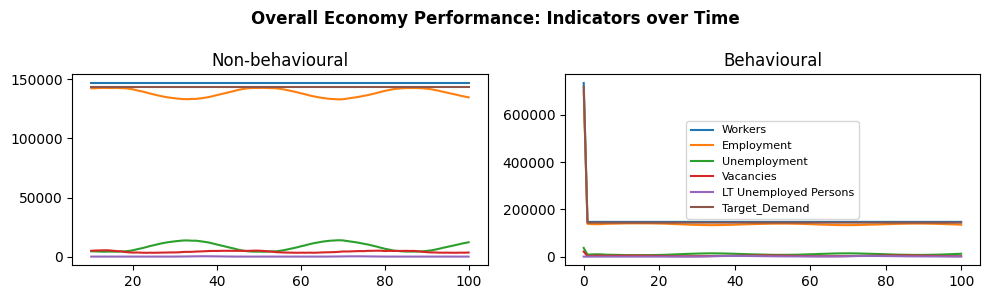

,index,Sim,Time Step,Employment,Unemployment,Workers,Vacancies,LT Unemployed Persons,Target_Demand


In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

totals = record1_f.loc[10:,['Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
lgd = []
for column in totals[1:]:
    ax1.plot(totals[column])
    lgd.append(column)
ax1.set_title("Non-behavioural")
    
totals = record1_t.loc[10:,['Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
for column in totals[1:]:
    ax2.plot(totals[column])
ax2.set_title('Behavioural')

fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
fig.tight_layout()

if final:
    plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

record1_f.loc[(macro_observations['DATE'] >= '2010-01-01') & (macro_observations['DATE'] <= "2019-12-01")].reset_index()


In [29]:
# unemmployment by duration
net_behav

## Unemployment and long-term unemployment rates

The below plots show the long-run behaviour of unemployment rate and long-term unemployment rate (defined as people unemployed for longer than 12 months). The oscillation results from a business cycle dynamic present in the model. This business cycle has yet to be calibrated but next step will be to calibrate the amplitude of this business cycle in line with GDP (suggestion from Maria in a recent technical check-in). 

The unemployment rate is high for the US...it generally fluctuates between 3-6%. Will look into adjusting this as well.  

The long-term unemployment rate (reported below as the proportion of unemployed workers in long-term unemployment) does look in line with observed real-world values (~15% of unemployed workers - with major fluctuations since the 2008 financial crisis, so might need to think a little more about what we want to target) in both models. 


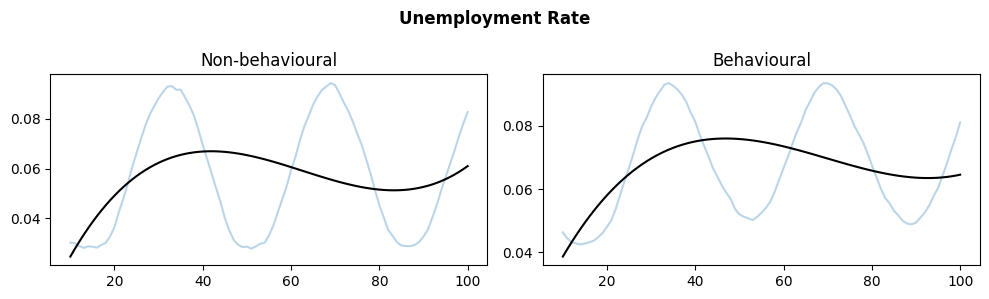

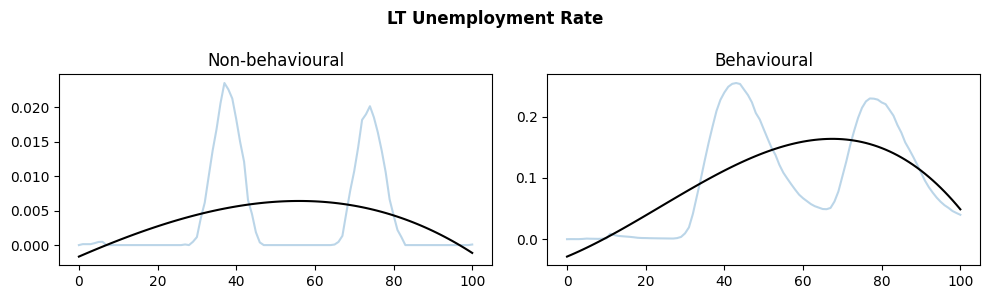

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ue_tot = record1_f.loc[10:,['Workers', 'Unemployment', 'LT Unemployed Persons']]
ue_tot['UE Rate'] = ue_tot['Unemployment'] / ue_tot['Workers']
ue_mean = ue_tot.loc[:, ['UE Rate']]
spl = splrep(ue_mean.index, ue_mean['UE Rate'], s=1)

temp = ue_mean
ax1.plot(temp['UE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ue_mean.index, BSpline(*spl)(ue_mean.index), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')


ue_tot = record1_t.loc[10:,['Workers', 'Unemployment', 'LT Unemployed Persons']]
ue_tot['UE Rate'] = ue_tot['Unemployment'] / ue_tot['Workers']
ue_mean = ue_tot.loc[:, ['UE Rate']]
spl = splrep(ue_mean.index, ue_mean['UE Rate'], s=2)

temp = ue_mean
ax2.plot(temp['UE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ue_mean.index, BSpline(*spl)(ue_mean.index), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/uer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()


# Long-term unemployment rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = record1_f.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons']]
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Unemployment']
ltue_mean = ltue_tot.loc[:, ['LTUE Rate']]
spl = splrep(ltue_mean.index, ltue_mean['LTUE Rate'], s=10)

temp = ltue_mean
ax1.plot(temp['LTUE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean.index, BSpline(*spl)(ltue_mean.index), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


ltue_tot = record1_t.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons']]
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Unemployment']
ltue_mean = ltue_tot.loc[:, ['LTUE Rate']]
spl = splrep(ltue_mean.index, ltue_mean['LTUE Rate'],  s=2)

temp = ltue_mean
ax2.plot(temp['LTUE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean.index, BSpline(*spl)(ltue_mean.index), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()


#### Optional plot saving code for saving to pdf

In [27]:
# with PdfPages('multipage_us_k.pdf') as pdf:
#     for del_u in [0.005]:#δ_u_list:
#         for del_v in [0.01]: #δ_v_list:
#                 gamma = 10*del_u
#                 print(["δ_u: " + str(del_u) + "; δ_v: " + str(del_v)])
#                 sim_record_f_all = run_sim(False, mod_data, T, 1, del_u, del_v)
#                 sim_record_t_all = run_sim(True, mod_data, T, 1, del_u, del_v)
#                 sim_record_t = sim_record_t_all.loc[(sim_record_t_all.Time > 0)]
#                 sim_record_f = sim_record_f_all.loc[(sim_record_f_all.Time > 0)]
#                 record1_f = sim_record_f.loc[(sim_record_f.Sim == 0)]
#                 record1_t = sim_record_t.loc[(sim_record_t.Sim == 0)]

#                 txt = ["δ_u: " + str(del_u) + "; δ_v: " + str(del_v)]
#                 ue_vac_f = record1_f.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
#                 ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
#                 ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
#                 ue_vac_f = ue_vac_f.loc[(ue_vac_f.Time > 300) & (ue_vac_f.Time < 327)]

#                 ue_vac_t = record1_t.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
#                 ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
#                 ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
#                 ue_vac_t = ue_vac_t.loc[(ue_vac_t.Time > 300) & (ue_vac_t.Time < 327)]


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

#                 ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
#                 ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f['Time'], s=100, lw=0)
#                 ax1.set_title("Non-behavioural")
#                 ax1.set_xlabel("UE Rate")
#                 ax1.set_ylabel("Vacancy Rate")

#                 ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
#                 ax2.set_title("Behavioural")
#                 ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t['Time'], s=100, lw=0)
#                 ax2.set_xlabel("UE Rate")
#                 ax2.set_ylabel("Vacancy Rate")

#                 fig.text(0.05,0.95,txt, transform=fig.transFigure, size=18)
#                 fig.suptitle("Beveridge Curve", fontweight = 'bold')
#                 fig.tight_layout()


#                 if final:
#                     plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 totals = record1_f.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 lgd = []
#                 for column in totals[1:]:
#                     ax1.plot(totals[column])
#                     lgd.append(column)
#                 ax1.set_title("Non-behavioural")

#                 totals = record1_t.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 for column in totals[1:]:
#                     ax2.plot(totals[column])
#                 ax2.set_title('Behavioural')

#                 fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
#                 plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()

#                 #### Occupations: Employment, Unemployment, Worker, Vacancy, and Longterm Unemployed Levels
#                 # # Overall indicators per occupation
#                 # ids = np.unique(record1_t.Occupation_ID)
#                 # fig = plt.figure(constrained_layout = False)

#                 # occ_totals = record1_t.loc[:,['Time', 'Occupation_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
#                 # for occ in ids:
#                 #     gtmp = occ_totals[(occ_totals['Occupation_ID'] == occ)].loc[:, ['Time', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 #     # Indicators (workers, employment, etc)
#                 #     fig.add_subplot(3, 2, int(occ)+1, title = f'Occ: {int(occ)}')
#                 #     lgd = []
#                 #     for column in gtmp[1:]:
#                 #         plt.plot(gtmp[column])
#                 #         lgd.append(column)

#                 # fig.suptitle("Economy Performance per Economy: Indicators over Time", fontweight = 'bold')
#                 # fig.legend(list(lgd), bbox_to_anchor=(0.9, 0.3), ncols = 1, title_fontsize = "6", fontsize="8")
#                 # fig.subplots_adjust(wspace=0.2, hspace = 0.75)
#                 # if final:
#                 #     plt.savefig('../output/occ_perf_base.jpg', dpi = 300)
#                 # else:
#                 #     plt.show()
#                 # plt.close(fig)
#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
#                     ax1.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.3)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax1.plot(temp['Time'], temp['UE Rate'])
#                 ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax1.set_title("Non-behavioural")
#                 fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


#                 ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
#                     ax2.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.2)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax2.plot(temp['Time'], temp['UE Rate'])
#                 ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax2.set_title("Behavioural")
#                 fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     ax1.plot(temp['Time'], temp['UE Rate'], alpha = 0.3)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax1.plot(temp['Time'], temp['UE Rate'])
#                 ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax1.set_title("Non-behavioural")
#                 fig.suptitle("Unemployment Rate", fontweight = 'bold')


#                 ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     ax2.plot(temp['Time'], temp['UE Rate'], alpha = 0.2)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax2.plot(temp['Time'], temp['UE Rate'])
#                 ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax2.set_title("Behavioural")
#                 fig.suptitle("Unemployment Rate", fontweight = 'bold')
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()

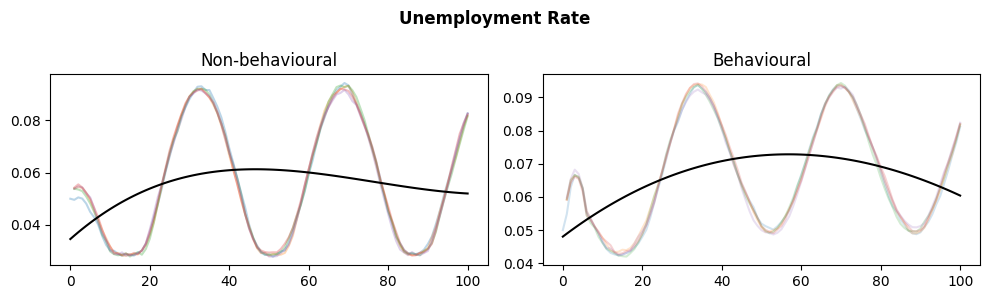

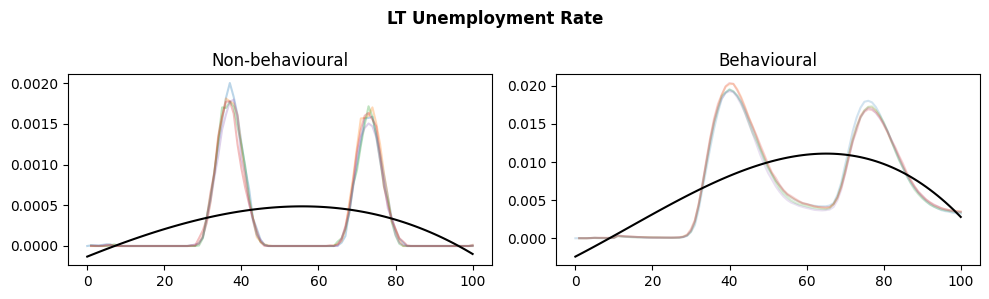

In [28]:
## Additional plotting code for when simluations - will need to modify array record to store results from multiple simulations

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time Step', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'UE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time Step']]
    ax1.plot(temp['Time Step'], temp['UE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time Step', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'UE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time Step']]
    ax2.plot(temp['Time Step'], temp['UE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

# INCLUDE WHEN DOING SIMULATIONS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time Step', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'LTUE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time Step']]
    ax1.plot(temp['Time Step'], temp['LTUE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time Step', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time Step', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time Step', 'LTUE Rate']].groupby(['Time Step']).mean().reset_index()
spl = splrep(ltue_mean['Time Step'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time Step']]
    ax2.plot(temp['Time Step'], temp['LTUE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time Step'], BSpline(*spl)(ltue_mean['Time Step']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
# colors = colors = ['b','g','r','y','m']

# sim_record_f['UE Rate'] = sim_record_f['Unemployment'] / sim_record_f['Workers']
# for o in np.unique(sim_record_f.Occupation_ID):
#     temp = sim_record_f[(sim_record_f['Occupation_ID'] == o)][['UE Rate', 'Time Step', 'Sim']]
#     temp_mean = temp.loc[:, ['Time Step', 'UE Rate']].groupby(['Time Step']).mean().reset_index()
#     spl = splrep(temp_mean['Time Step'], temp_mean['UE Rate'], s=2)
#     for g in np.unique(temp.Sim):
#         ax1.plot(temp[(temp['Sim'] == g)]['Time Step'], temp[(temp['Sim'] == g)]['UE Rate'], alpha = 0.05, color = colors[o])
#     ax1.plot(temp_mean['Time Step'], BSpline(*spl)(temp_mean['Time']), '-', color = colors[o])
# ax1.set_title("Non-behavioural")
# fig.suptitle("Unemployment Rate", fontweight = 'bold')

# sim_record_t['UE Rate'] = sim_record_t['Unemployment'] / sim_record_t['Workers']
# for o in np.unique(sim_record_t.Occupation_ID):
#     temp = sim_record_t[(sim_record_t['Occupation_ID'] == o)][['UE Rate', 'Time Step', 'Sim']]
#     temp_mean = temp.loc[:, ['Time Step', 'UE Rate']].groupby(['Time']).mean().reset_index()
#     spl = splrep(temp_mean['Time Step'], temp_mean['UE Rate'], s=3)
#     for g in np.unique(temp.Sim):
#         ax2.plot(temp[(temp['Sim'] == g)]['Time Step'], temp[(temp['Sim'] == g)]['UE Rate'], alpha = 0.05, color = colors[o])
#     ax2.plot(temp_mean['Time Step'], BSpline(*spl)(temp_mean['Time Step']), '-', color = colors[o])
# ax2.set_title("Behavioural")
# fig.suptitle("Unemployment Rate by Occupation", fontweight = 'bold')
# fig.tight_layout()